Necessary packages: pyprg (pip), theano, tensorflow

Example setting up conda environment:
```
conda create -n dragonn_kernel python=2.7 ipykernel theano matplotlib pydot-ng graphviz
# register kernel
python -m ipykernel install --user
# dependency
pip install pyprg
# install dragonn 0.1.3 from source
git clone https://github.com/kundajelab/dragonn.git
cd dragonn
python setup.py install
```

Activate environment (`conda activate dragonn_kernel`) and then start notebook.

`dragonn` depends on `keras 0.3.2`, which I do not think was written for `tensorflow >0.10`. In the newer versions of `tensorflow` it requires named arguments in one of the functions and throws the error 

`ValueError: Only call `sigmoid_cross_entropy_with_logits` with named arguments (labels=..., logits=..., ...)`

I tried using the `dev-tf` branch of `deeplift` which was developed with `tensorflow 1.0` but it seems the code has been reorganized enough that `dragonn` doesn't like that version. In the `setup.py` of `dragonn` it only requires `deeplift=0.5.1-theano`, but in the code it kept running Tensorflow backend. I went in and edited `~/.keras/keras.json` and changed it to `backend : 'theano'` instead of `tensorflow`.

In [1]:
from dragonn.tutorial_utils import *
import dragonn
%matplotlib inline

We've confirmed the simulation works, let's try running it on command line with the following

```
dragonn train --pos-sequences ../processed_data/dragonn_output/tss_positives.fasta --neg-sequences ../processed_data/dragonn_output/tss_negatives.fasta --prefix ../processed_data/dragonn_output/endo_tss
```

This will store a model file, endo_tss.json, with the model architecture and a weights file, endo_tss.weights.h5, with the parameters of the trained model. Test the model by running:

```
dragonn test --pos-sequences ../processed_data/dragonn_output/tss_positives.fasta --neg-sequences ../processed_data/dragonn_output/tss_negatives.fasta --arch-file ../processed_data/dragonn_output/endo_tss.arch.json --weights-file ../processed_data/dragonn_output/endo_tss.weights.h5
```

Model performance:
```
Loss: 0.3499	Balanced Accuracy: 87.53%	 auROC: 0.934	 auPRC: 0.663
	Recall at 5%|10%|20% FDR: 3.3%|4.5%|14.7%	 Num Positives: 2101	 Num Negatives: 15284
```

To test on new sequences in the future:
```
dragonn predict --sequences example_sequences.fa --arch-file endo_tss.arch.json --weights-file endo_tss.weights.h5 --output-file predictions.txt
```

In [2]:
from dragonn.models import SequenceDNN
arch_file = '../processed_data/dragonn_output/endo_tss.arch.json'
weights_file = '../processed_data/dragonn_output/endo_tss.weights.h5'
model = SequenceDNN.load(arch_file, weights_file)

Using Theano backend.
/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/backend/theano_backend.py:788: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/backend/theano_backend.py:788: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/backend/theano_backend.py:788: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')
/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/theano/tensor/basic.py:2184: UserWarning: theano.tensor.round() chang

The validation metrics aren't stored in the saved model. Let's train the model here in this notebook, copying the code over from `__main__.py` from `dragonn`

In [3]:
import numpy as np, random
np.random.seed(1)
random.seed(1)
from dragonn.utils import encode_fasta_sequences, get_sequence_strings
try:
    from sklearn.model_selection import train_test_split  # sklearn >= 0.18
except ImportError:
    from sklearn.cross_validation import train_test_split  # sklearn < 0.18

In [4]:
pos_sequences = '../processed_data/dragonn_output/tss_positives.fasta'
neg_sequences = '../processed_data/dragonn_output/tss_negatives.fasta'

print("loading sequence data...")
X_pos = encode_fasta_sequences(pos_sequences)
y_pos = np.array([[True]]*len(X_pos))
X_neg = encode_fasta_sequences(neg_sequences)
y_neg = np.array([[False]]*len(X_neg))
X = np.concatenate((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))
X_train0, X_test, y_train0, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train0, y_train0, test_size=0.2)

print("initializing model...")
model = SequenceDNN(seq_length=X_train.shape[-1])

loading sequence data...
initializing model...


Hold out test set 20%, training set 60%, validation 20%

In [5]:
prefix = '../processed_data/dragonn_output/endo_tss'

print("starting model training...")
model.train(X_train, y_train, validation_data=(X_valid, y_valid), 
            save_best_model_to_prefix='../processed_data/dragonn_output/endo_tss_best')
valid_result = model.test(X_valid, y_valid)
print("final validation metrics:")
print(valid_result)
print("saving model files..")
model.save(prefix)
print("Done!")

starting model training...
Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.5980	Balanced Accuracy: 71.68%	 auROC: 0.780	 auPRC: 0.333
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1364	 Num Negatives: 9762
Valid Loss: 0.5995	Balanced Accuracy: 70.51%	 auROC: 0.770	 auPRC: 0.271
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 319	 Num Negatives: 2463 *
Epoch 2:
Train Loss: 0.5141	Balanced Accuracy: 73.65%	 auROC: 0.809	 auPRC: 0.365
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1364	 Num Negatives: 9762
Valid Loss: 0.5218	Balanced Accuracy: 72.14%	 auROC: 0.791	 auPRC: 0.293
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 319	 Num Negatives: 2463 *
Epoch 3:
Train Loss: 0.5064	Balanced Accuracy: 75.89%	 auROC: 0.827	 auPRC: 0.397
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1364	 Num Negatives: 9762
Valid Loss: 0.5206	Balanced Accuracy: 71.58%	 auROC: 0.799	 auPRC: 0.307
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0

Using plotting code from tutorial_utils.py

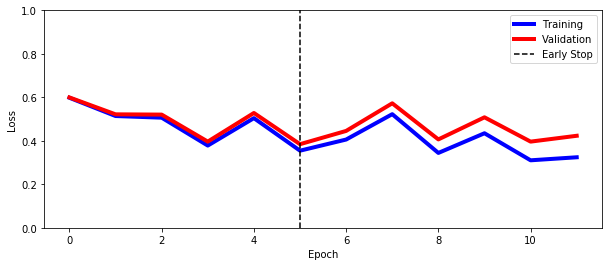

In [6]:
SequenceDNN_learning_curve(model)

In [7]:
# test model against all sequences
print("loading sequence data...")
# X_test_pos = encode_fasta_sequences(pos_sequences)
# y_test_pos = np.array([[True]]*len(X_test_pos))
# X_test_neg = encode_fasta_sequences(neg_sequences)
# y_test_neg = np.array([[False]]*len(X_test_neg))
# X_test = np.concatenate((X_test_pos, X_test_neg))
# y_test = np.concatenate((y_test_pos, y_test_neg))
# load model
print("loading model...")
model = SequenceDNN.load(arch_file, weights_file)
# test
print("testing model...")
test_result = model.test(X_test, y_test)
print(test_result)

loading sequence data...
loading model...
testing model...
Loss: 0.4251	Balanced Accuracy: 72.40%	 auROC: 0.814	 auPRC: 0.380
	Recall at 5%|10%|20% FDR: 1.0%|2.6%|4.3%	 Num Positives: 418	 Num Negatives: 3059


In [8]:
arch_file = '../processed_data/dragonn_output/endo_tss_best.arch.json'
weights_file = '../processed_data/dragonn_output/endo_tss_best.weights.h5'
print("loading model...")
best_model = SequenceDNN.load(arch_file, weights_file)
# test
print("testing model...")
best_test_result = best_model.test(X_test, y_test)
print(best_test_result)

loading model...
testing model...
Loss: 0.3864	Balanced Accuracy: 69.65%	 auROC: 0.811	 auPRC: 0.371
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 418	 Num Negatives: 3059


In [9]:
Data = namedtuple('Data', ('X_train', 'X_valid', 'y_train', 'y_valid'))
data = Data(X_train, X_valid, y_train, y_valid)

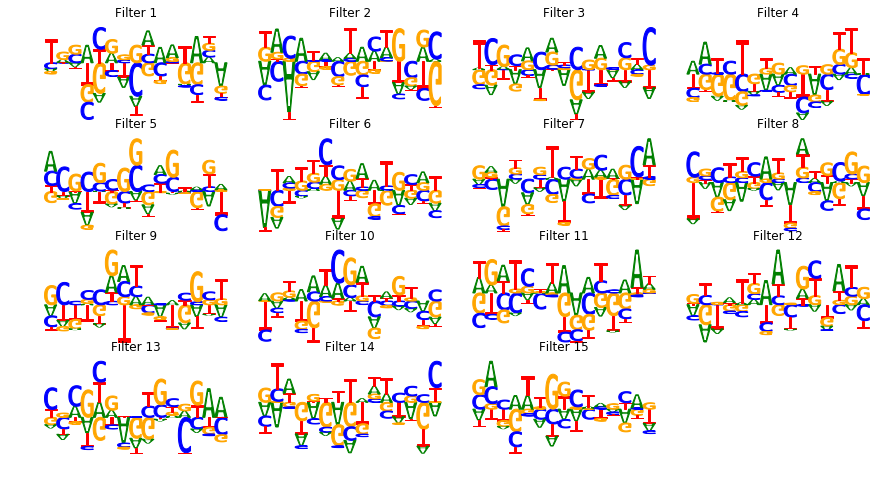

In [10]:
plot_sequence_filters(model)

-35 consensus: TTGACA, -10 consensus: TATAAT

In [11]:
# adapted to exclude motif name information
def plot_SequenceDNN_layer_outputs(dnn, simulation_data):
    # define layer out functions
    import theano
    get_conv_output = theano.function([dnn.model.layers[0].input],
                                      dnn.model.layers[0].get_output(train=False),
                                          allow_input_downcast=True)
    get_conv_relu_output = theano.function([dnn.model.layers[0].input],
                                            dnn.model.layers[1].get_output(train=False),
                                            allow_input_downcast=True)
    get_maxpool_output = theano.function([dnn.model.layers[0].input],
                                         dnn.model.layers[-4].get_output(train=False),
                                         allow_input_downcast=True)
    # get layer outputs for a positive simulation example
    pos_indx = np.where(simulation_data.y_valid==1)[0][0]
    pos_X = simulation_data.X_valid[pos_indx:(pos_indx+1)]
    conv_outputs = get_conv_output(pos_X).squeeze()
    conv_relu_outputs = get_conv_relu_output(pos_X).squeeze()
    maxpool_outputs = get_maxpool_output(pos_X).squeeze()
    # plot layer outputs
    fig = plt.figure(figsize=(15, 12))
    ax1 = fig.add_subplot(3, 1, 3)
    heatmap = ax1.imshow(conv_outputs, aspect='auto', interpolation='None', cmap='seismic')
    fig.colorbar(heatmap)
    ax1.set_ylabel("Convolutional Filters")
    ax1.set_xlabel("Position")
    ax1.get_yaxis().set_ticks([])
    ax1.get_xaxis().set_ticks([])
    ax1.set_title("SequenceDNN outputs from convolutional layer")

    ax2 = fig.add_subplot(3, 1, 2)
    heatmap = ax2.imshow(conv_relu_outputs, aspect='auto', interpolation='None', cmap='seismic')
    fig.colorbar(heatmap)
    ax2.set_ylabel("Convolutional Filters")
    ax2.get_yaxis().set_ticks([])
    ax2.get_xaxis().set_ticks([])
    ax2.set_title("Convolutional outputs after ReLU transformation")

    ax3 = fig.add_subplot(3, 1, 1)
    heatmap = ax3.imshow(maxpool_outputs, aspect='auto', interpolation='None', cmap='seismic')
    fig.colorbar(heatmap)
    ax3.set_title("DNN outputs after max pooling")
    ax3.set_ylabel("Convolutional Filters")
    ax3.get_yaxis().set_ticks([])
    ax3.get_xaxis().set_ticks([])

#     # highlight motif sites
#     motif_scores = get_motif_scores(pos_X, simulation_data.motif_names)
#     motif_sites = [np.argmax(motif_scores[0, i, :]) for i in [0, 1]]
#     for motif_site in motif_sites:
#         conv_output_start = motif_site - max(dnn.conv_width-10, 0)
#         conv_output_stop = motif_site + max(dnn.conv_width-10, 0)
#         ax1.axvspan(conv_output_start, conv_output_stop, color='grey', alpha=0.5)
#         ax2.axvspan(conv_output_start, conv_output_stop, color='grey', alpha=0.5)

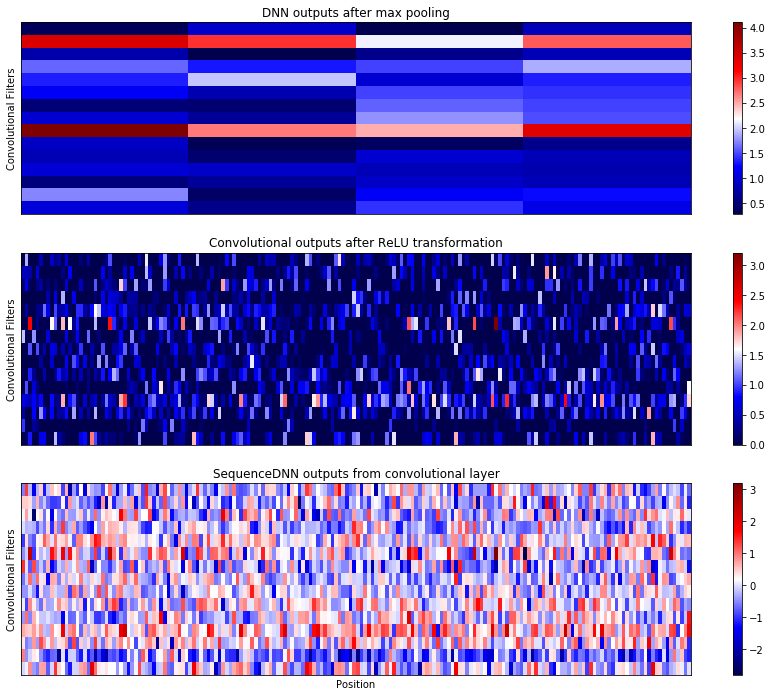

In [12]:
plot_SequenceDNN_layer_outputs(model, data)

In [13]:
model.plot_architecture('endo_tss_architecture.png')

RuntimeError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

Let's try doing a hyperparameter search (code taken from `simple_motif_detection.py` on the github)

In [14]:
print('Starting hyperparameter search...')
from dragonn.hyperparameter_search import HyperparameterSearcher, RandomSearch

seq_length = 100
use_RNN = False
use_deep_CNN = False
num_epochs = 100
num_hyperparameter_trials = 50

fixed_hyperparameters = {'seq_length': seq_length, 'use_RNN': use_RNN, 'num_epochs': num_epochs}
grid = {'num_filters': ((5, 100),), 'pool_width': (5, 40),
        'conv_width': ((6, 20),), 'dropout': (0, 0.5)}
if use_deep_CNN:
    grid.update({'num_filters': ((5, 100), (5, 100), (5, 100)),
                 'conv_width': ((6, 20), (6, 20), (6, 20))})
if use_RNN:
    grid.update({'GRU_size': (10, 50), 'TDD_size': (20, 60)})

# Backend is RandomSearch; if using Python 2, can also specify MOESearch
# (requires separate installation)
searcher = HyperparameterSearcher(SequenceDNN, fixed_hyperparameters, grid, X_train, y_train,
                                  validation_data=(X_valid, y_valid), backend=RandomSearch)
searcher.search(num_hyperparameter_trials)
print('Best hyperparameters: {}'.format(searcher.best_hyperparameters))
tuned_model = searcher.best_model

Starting hyperparameter search...
Training model (* indicates new best result)...


ValueError: cannot reshape array of size 117504 into shape (128,432)
Apply node that caused the error: Reshape{2}(Pool{ignore_border=True, mode='max', ndim=2}.0, MakeVector{dtype='int64'}.0)
Toposort index: 53
Inputs types: [TensorType(float32, 4D), TensorType(int64, vector)]
Inputs shapes: [(128, 54, 1, 17), (2,)]
Inputs strides: [(3672, 68, 68, 4), (8,)]
Inputs values: ['not shown', array([128, 432])]
Outputs clients: [[InplaceDimShuffle{1,0}(Reshape{2}.0), Dot22(Reshape{2}.0, dense_W)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/models.py", line 507, in compile
    self.y_train = self.get_output(train=True)
  File "/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/layers/containers.py", line 130, in get_output
    return self.layers[-1].get_output(train)
  File "/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/layers/core.py", line 737, in get_output
    X = self.get_input(train)
  File "/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/layers/core.py", line 241, in get_input
    previous_output = self.previous.get_output(train=train)
  File "/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/layers/core.py", line 1030, in get_output
    X = self.get_input(train)
  File "/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/layers/core.py", line 241, in get_input
    previous_output = self.previous.get_output(train=train)
  File "/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/layers/core.py", line 901, in get_output
    return K.batch_flatten(X)
  File "/Users/Kimberly/anaconda2/envs/dragonn_kernel/lib/python2.7/site-packages/Keras-0.3.3-py2.7.egg/keras/backend/theano_backend.py", line 314, in batch_flatten
    x = T.reshape(x, (x.shape[0], T.prod(x.shape) // x.shape[0]))

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

Let's try using dropout.

In [ ]:
print("initializing model...")
model_dropout = SequenceDNN(seq_length=X_train.shape[-1], dropout=0.20)
prefix = '../processed_data/dragonn_output/endo_tss_dropout'

print("starting model training...")
model_dropout.train(X_train, y_train, validation_data=(X_valid, y_valid), 
            save_best_model_to_prefix='../processed_data/dragonn_output/endo_tss_dropout_best')
valid_result = model_dropout.test(X_valid, y_valid)
print("final validation metrics:")
print(valid_result)
print("saving model files..")
model.save(prefix)
print("Done!")
SequenceDNN_learning_curve(model_dropout)

In [ ]:
plot_sequence_filters(model_dropout)

In [ ]:
model_dropout.plot_architecture('../processed_data/dragonn_output/endo_tss_dropout_architecture.png')

In [ ]:
arch_file = '../processed_data/dragonn_output/endo_tss_dropout_best.arch.json'
weights_file = '../processed_data/dragonn_output/endo_tss_dropout_best.weights.h5'
print("loading model...")
best_dropout_model = SequenceDNN.load(arch_file, weights_file)
# test
print("testing model...")
best_dropout_test_result = best_dropout_model.test(X_test, y_test)
print(best_dropout_test_result)

In [ ]:
# graph PRC
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
precision, recall, _ = precision_recall_curve(y_test, best_dropout_model.predict(X_test))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

In [ ]:
# graph ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=best_dropout_model.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr,
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plot_SequenceDNN_layer_outputs(model_dropout, data)

In [ ]:
import numpy as np
from collections import namedtuple, defaultdict, OrderedDict
pos_idx = np.flatnonzero(y_valid==1)[2]
neg_idx = np.flatnonzero(y_valid==0)[2]
pos_X = X_valid[pos_idx:pos_idx+1]
neg_X = X_valid[neg_idx:neg_idx+1]

# get motif scores, ISM scores, and DeepLIFT scores
scores_dict = defaultdict(OrderedDict)
scores_dict['Positive']['ISM Scores'] =  model_dropout.in_silico_mutagenesis(pos_X).max(axis=-2)
# scores_dict['Positive']['DeepLIFT Scores'] = model_dropout.deeplift(pos_X).max(axis=-2)
scores_dict['Negative']['ISM Scores'] =  model_dropout.in_silico_mutagenesis(neg_X).max(axis=-2)
# scores_dict['Negative']['DeepLIFT Scores'] = model_dropout.deeplift(neg_X).max(axis=-2)

In [ ]:
model_dropout.plot_in_silico_mutagenesis(pos_X, output_directory='../processed_data/dragonn_output')